**Morro Bay Triathlon Machine Learning**

Roee Morag

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np
import altair as alt
from sklearn.model_selection import cross_val_score

In [2]:
df_tri = pd.read_csv("morro_triathlon.csv")

For the first part, I'm going to run some simple linear regression using two of the legs to predict the time of the last one. This isn't going to be the largest portion of my machine learning aspect - this is just for curiosity about my own times and to see which two sports are the best predictor of the last one.

In [3]:
df_swim_bike = df_tri.dropna(subset=["Swim Time", "Bike Time", "Run Time"])

In [4]:
X_train1 = df_swim_bike[["Swim Time", "Bike Time"]]
X_test = df_swim_bike[["Swim Time", "Bike Time"]]
y_train1 = df_swim_bike["Run Time"]

run_model = LinearRegression()
run_model.fit(X=X_train1, y=y_train1)

LinearRegression()

In [5]:
df_swim_bike["Pred Run"] = run_model.predict(X=X_test)

In [6]:
run_model.predict([[17, 55]])  # Numbers from my own triathlon. I ran faster than predicted based on my swimming and biking times.

C:\Users\morag\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([47.02338798])

In [7]:
df_swim_bike['Color'] = df_swim_bike['First Name'] == "Roee"

In [8]:
alt.Chart(df_swim_bike).mark_point().encode(
    x="Run Time",
    y="Pred Run",
    tooltip=["Run Time", "Pred Run"],
    color="Color"
).interactive()

alt.Chart(...)

In [9]:
X_train2 = df_swim_bike[["Swim Time", "Run Time"]]
X_test = df_swim_bike[["Swim Time", "Run Time"]]
y_train2 = df_swim_bike["Bike Time"]

bike_model = LinearRegression()
bike_model.fit(X=X_train2, y=y_train2)

LinearRegression()

In [10]:
df_swim_bike["Pred Bike"] = bike_model.predict(X=X_test)

In [11]:
bike_model.predict([[17, 39]])

C:\Users\morag\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([40.77574396])

In [12]:
alt.Chart(df_swim_bike).mark_point().encode(
    x="Bike Time",
    y="Pred Bike",
    tooltip=["Bike Time", "Pred Bike"],
    color="Color"
).interactive()

alt.Chart(...)

In [13]:
X_train3 = df_swim_bike[["Bike Time", "Run Time"]]
X_test = df_swim_bike[["Bike Time", "Run Time"]]
y_train3 = df_swim_bike["Swim Time"]

swim_model = LinearRegression()
swim_model.fit(X=X_train3, y=y_train3)

LinearRegression()

In [14]:
df_swim_bike["Pred Swim"] = swim_model.predict(X=X_test)

In [15]:
swim_model.predict([[55, 39]])

C:\Users\morag\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([21.00918492])

In [16]:
alt.Chart(df_swim_bike).mark_point().encode(
    x="Swim Time",
    y="Pred Swim",
    tooltip=["Swim Time", "Pred Swim"],
    color="Color"
).interactive()

alt.Chart(...)

In [17]:
-cross_val_score(run_model, X_train1, y=y_train1, cv=5,
                scoring="neg_mean_squared_error").mean()

np.float64(32.0658795628848)

In [18]:
-cross_val_score(bike_model, X_train2, y=y_train2, cv=5,
                scoring="neg_mean_squared_error").mean()

np.float64(21.01589644700677)

In [19]:
-cross_val_score(swim_model, X_train3, y=y_train3, cv=5,
                scoring="neg_mean_squared_error").mean()

np.float64(16.363843098515233)

The model which predicted swimming times had the lowest mean squared error, meaning its the best model. It is important to note that the variables were not scaled. I chose not to scale the variables to put more emphasis on the biking (as it is the longest portion of the race). However in doing so, it becomes easier to predict the swimming times as they are bound by a tighter range. One possibility is that swimming time can differentiate the elite triathletes from the rest. A good swimming time is associated with good times in the other legs while somebody who struggles in the swimming is likely to struggle in the rest of the race.

There is also something to be said about the order of the race. Athletes who start off well in the swimming portion might carry that momentum through the rest of the race and those who start slow might struggle to regain their mojo.

Moving on to more meaningful analysis of the data:

I'm going to use running time and swimming time to predict the overall time. I've decided to exclude biking to make it more applicable to myself and my training. In my training, I don't have access to a bike and I don't have the time needed to get better. As a result, I've focused on my swimming and running and hoping the cardio I've gained will carry through to the biking. This is also applicable to all triathletes without access to a bike - a more common problem amongst the college aged athletes.

Firstly, I'm going to run a linear regression model using the swimming and the biking times. Then, I will run a k-nearest neighbors regression using the same variables and compare the models.

In the data visualization notebook, I did not see a noticable difference in overall finish times amongst different age groups. To see if it adds to the model, I will create a k-nearest neighbor regression model adding the categorical age variable. I will tune the k-nearest neighbors model using grid search and compare all the models at the end to find the best predictor of overall time.

In [20]:
X_train = df_tri[["Swim Time", "Run Time"]]
y_train = df_tri["Time"]

In [21]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline

ct_two_var = make_column_transformer((StandardScaler(), ["Swim Time", "Run Time"]))

linear_model = make_pipeline(ct_two_var, LinearRegression())
linear_model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['Swim Time', 'Run Time'])])),
                ('linearregression', LinearRegression())])

In [22]:
from sklearn.neighbors import KNeighborsRegressor

knn_twovar_mod = make_pipeline(ct_two_var, KNeighborsRegressor(n_neighbors=6))

In [23]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(knn_twovar_mod,
                           param_grid={
                               "kneighborsregressor__n_neighbors": range(1, 20)
                           },
                           scoring="neg_mean_squared_error",
                           cv=10)
grid_search.fit(X_train, y_train)
grid_search.best_estimator_

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['Swim Time', 'Run Time'])])),
                ('kneighborsregressor', KNeighborsRegressor(n_neighbors=12))])

In [24]:
df_cv_results_ = pd.DataFrame(grid_search.cv_results_)

df_cv_results_["param_kneighborsregressor__n_neighbors"] = df_cv_results_["param_kneighborsregressor__n_neighbors"].astype(int)
df_cv_results_.set_index("param_kneighborsregressor__n_neighbors", inplace = True)

<Axes: title={'center': 'kNN with 2 Features'}, xlabel='k', ylabel='test error'>

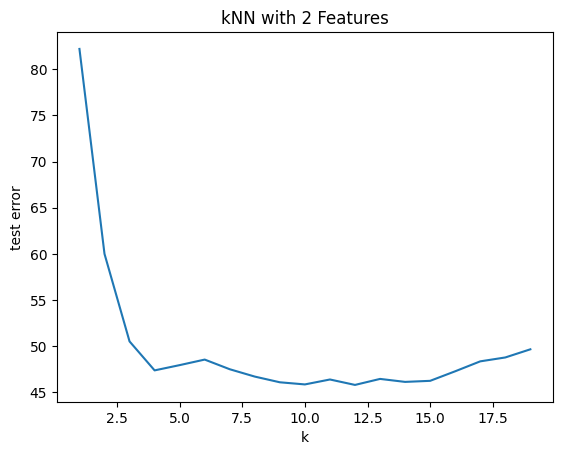

In [25]:
(-df_cv_results_["mean_test_score"]).plot.line(xlabel = "k", ylabel = "test error", title = "kNN with 2 Features")

The mean square error for kNN with 2 quantitative features is minimized at k=10.


In [26]:
knn_twovar_mod = make_pipeline(ct_two_var, KNeighborsRegressor(n_neighbors=10))
knn_twovar_mod.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['Swim Time', 'Run Time'])])),
                ('kneighborsregressor', KNeighborsRegressor(n_neighbors=10))])

Now onto the final model, one that incorporates age as a categorical variable. We will again use Hyperparamater Tuning to find the value for k that minimizes the mean squared error.

In [27]:
X_train = df_tri[["Run Time", "Swim Time", "AgeCat"]]

In [28]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

ct_knn = make_column_transformer(
    (StandardScaler(), ["Run Time", "Swim Time"]),
    (OneHotEncoder(), ["AgeCat"]),
    remainder="drop"  # all other columns in X will be dropped.
)

In [29]:
knn_mod = make_pipeline(ct_knn, KNeighborsRegressor(n_neighbors=6))

In [30]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(knn_mod,
                           param_grid={
                               "kneighborsregressor__n_neighbors": range(1, 20)
                           },
                           scoring="neg_mean_squared_error",
                           cv=10)
grid_search.fit(X_train, y_train)
grid_search.best_estimator_

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['Run Time', 'Swim Time']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['AgeCat'])])),
                ('kneighborsregressor', KNeighborsRegressor(n_neighbors=7))])

In [31]:
df_cv_results_ = pd.DataFrame(grid_search.cv_results_)

df_cv_results_["param_kneighborsregressor__n_neighbors"] = df_cv_results_["param_kneighborsregressor__n_neighbors"].astype(int)
df_cv_results_.set_index("param_kneighborsregressor__n_neighbors", inplace = True)

<Axes: title={'center': 'kNN with 2 Features'}, xlabel='k', ylabel='test error'>

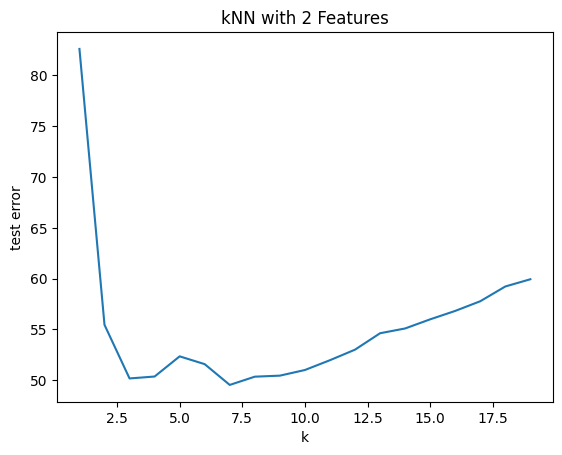

In [32]:
(-df_cv_results_["mean_test_score"]).plot.line(xlabel = "k", ylabel = "test error", title = "kNN with 2 Features")

The mean square error for kNN with 2 quantitative features and 1 categorical feature is minimized at k=3. Lets complete that model.

In [33]:
knn_mod = make_pipeline(ct_two_var, KNeighborsRegressor(n_neighbors=3))
knn_mod.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['Swim Time', 'Run Time'])])),
                ('kneighborsregressor', KNeighborsRegressor(n_neighbors=3))])

To keep track of progress:

**Model 1**: 2 Quantitave Predictors w/ Linear Regression

**Model 2**: 2 Quantitative Predictors w/ kNN (k=10)

**Model 3**: 2 Quantitative Predictors and a Cat Predictor (k=3)

In [34]:
scores = cross_val_score(linear_model,
                         X=df_tri[["Run Time", "Swim Time"]],
                         y=y_train,
                         scoring="neg_mean_squared_error",
                         cv=5)

model1_err = np.sqrt(-scores).mean()

In [35]:
scores = cross_val_score(knn_twovar_mod,
                         X=df_tri[["Run Time", "Swim Time"]],
                         y=y_train,
                         scoring="neg_mean_squared_error",
                         cv=5)

model2_err = np.sqrt(-scores).mean()

In [36]:
scores = cross_val_score(knn_mod,
                         X=X_train,
                         y=y_train,
                         scoring="neg_mean_squared_error",
                         cv=5)

model3_err = np.sqrt(-scores).mean()

In [37]:
print(model1_err, model2_err, model3_err)

6.0147955105872 6.5531778346012555 7.121131783778227
6.0147955105872 6.5531778346012555 7.121131783778227


Using the cross validation estimates of test error for each of the three models, we see that Model 1 has the lowest RMSE. The simplest model, solely utilizing Linear Regression, is off on predicting the finish time by an average of 6.015 minutes, compared to 6.53 and 7.11 minutes done by the other two models. The data we have is very linear; the faster you do the running, swimming, or biking portion, the faster your overall time. The most interesting observation from the machine learning aspect of this project is that age is just a number when it comes to triathletes. The model that took age into account performed significantly worse than both models that ignored that variable.